<p align="center">
<img style="width:90%;" src="https://cdn.pixabay.com/photo/2016/04/30/08/35/aircraft-1362586_960_720.jpg">
</p>

[Image source](https://pixabay.com/photos/aircraft-sunset-silhouette-clouds-1362586/)


<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Airline passengers with SARIMAX. </h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/TimeSeries/AirlinePassengers/SarimaxAirlinePassengers.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1.	[EDA](#step1)
## 2.	[Test harness](#step2)
## 3.	[Choosing SARIMAX parameters](#step3)
## 4.	[SARIMAX](#step4)
## 5.	[SARIMAX grid search](#step5)
## 6.	[Check residuals](#step6)
## 7.	[Test scoring](#step7)
## 8.   [Summary](step8#)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
from matplotlib import cm
from statsmodels.api import qqline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Configure Matplotlib and seaborn
plt.style.use('seaborn-muted')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

In [3]:
series = pd.read_csv('Data/international-airline-passengers.csv',
                     index_col=0, parse_dates=True,
                     squeeze=True, names=['Month', 'Passengers'],
                     header=0,
                     )
series = series[:-1].astype('int')
series.index = pd.to_datetime(series.index)

# Create a pivot table for data
df = pd.DataFrame()
df['Month'] = series.index.month
df['Year'] = series.index.year
df['Date'] = series.index
df['Passengers'] = series.values
df_pivot = pd.pivot_table(df, values='Passengers', columns='Year',
                          index='Month')

<div id="step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. EDA. </span>

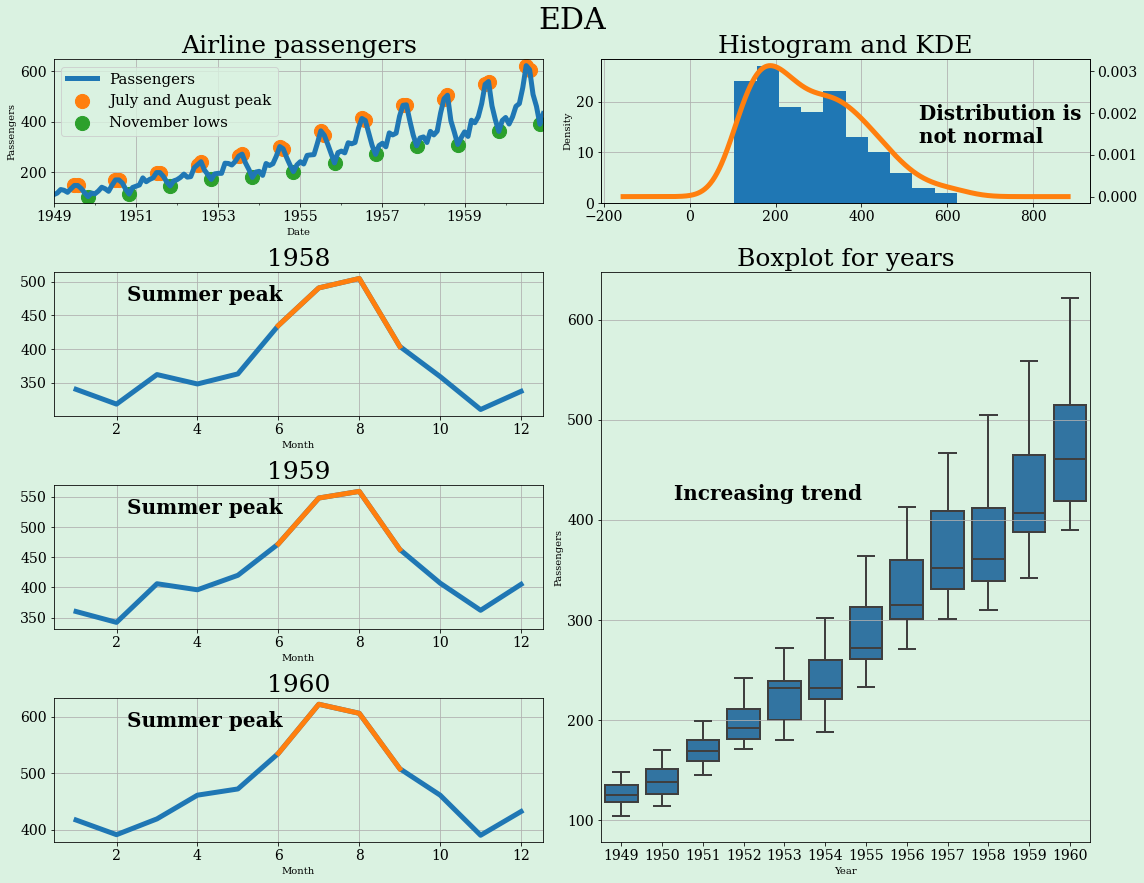

In [4]:
fig = plt.figure(figsize=(16, 15))
layout = (5, 2)
line_ax = plt.subplot2grid(layout, (0, 0))
hist_ax = plt.subplot2grid(layout, (0, 1))
series.plot(ax=line_ax, label='Passengers', color=blue)
df[df['Month'].isin([7, 8])].plot(x='Date', y='Passengers', kind='scatter',
                                  ax=line_ax, color=orange, s=200,
                                  label='July and August peak', zorder=2)
df[df['Month'].isin([11])].plot(x='Date', y='Passengers', kind='scatter',
                                  ax=line_ax, color=green, s=200,
                                  label='November lows', zorder=2)
line_ax.set_title('Airline passengers')
line_ax.legend(fontsize=15)
series.plot(kind='hist', ax=hist_ax, zorder=10, color=blue)
series.plot(kind='kde', ax=hist_ax, secondary_y=True, color=orange)
hist_ax.text(0.65, 0.42, 'Distribution is\nnot normal',
             transform = hist_ax.transAxes, size=20, fontweight='bold')
hist_ax.right_ax.grid(False)
hist_ax.grid(True, zorder=0)
hist_ax.set_title('Histogram and KDE');

axes = [plt.subplot2grid(layout, (1, 0)), plt.subplot2grid(layout, (2, 0)),
        plt.subplot2grid(layout, (3, 0))]

years = ['1958', '1959', '1960']
df_pivot.loc[:, years[0]:years[-1]].plot(kind='line', subplots=True,
                                    grid=True, color=blue,
                                    legend=False,
                                    title=years,
                                    ax=axes)
df_pivot.loc[6:9, years[0]:years[-1]].plot(kind='line', subplots=True,
                                      grid=True,  color=orange,
                                      ax=axes, legend=False,
                                      title=years)
for i in range(len(years)):
    axes[i].text(0.15, 0.8, 'Summer peak', transform=axes[i].transAxes,
                    size=20, fontweight='bold')
# Boxplot
boxplot_ax = plt.subplot2grid(layout, (1, 1), rowspan=3)
sns.boxplot(x='Year', y='Passengers', linewidth=2, data=df,
            color=blue, ax=boxplot_ax)
boxplot_ax.text(0.15, 0.6, 'Increasing trend', transform=boxplot_ax.transAxes,
                size=20, fontweight='bold')
boxplot_ax.set_title('Boxplot for years')
plt.suptitle('EDA')
plt.tight_layout();

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 1 results:</h2>

### 1. **Increasing trend** over years.
### 2. **Seasonality** - with peak at summer (July and August) and very low periods - November (February).
### 3. **Distribution is not normal** - Power Transform of data can help to improve prediction results.


<div id="step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Test harness: Train-test split, scoring function, baseline. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Will use RMSE as a metric to punish for highly inaccurate predictions.</h3>
$
\ \huge RMSE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}
$

In [5]:
def score_model(y_test, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse = rmse.round(3)
    return rmse

In [6]:
def manual_split(series, train_size=0.6, validation_size=0.2):
    train_size = int(len(series) * train_size)
    validation_size = int(len(series) * validation_size)
    train = series.iloc[:train_size]
    validation = series.iloc[train_size:(train_size + validation_size)]
    test = series.iloc[(train_size + validation_size):]
    return train, validation, test

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">As a baseline will use the persistence model. Persistence model predicts the value in t+1 period to be the same as value in t period.</h3>
$
\ \huge value_{(t)} = observation_{(t-1)}
$

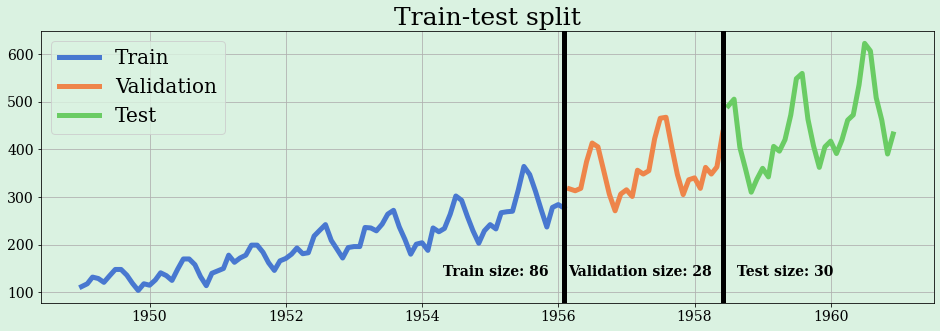

In [7]:
def plot_split(train, validation, test):
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(train, label='Train')
    ax.plot(validation, label='Validation')
    ax.plot(test, label='Test')
    ax.axvline(max(train.index), color='black')
    ax.axvline(max(validation.index), color='black')
    ax.set_title('Train-test split');

    ax.text(0.45, 0.1, f'Train size: {len(train)}',
            transform = ax.transAxes, size=14, fontweight='bold')
    ax.text(0.59, 0.1, f'Validation size: {len(validation)}',
            transform = ax.transAxes, size=14, fontweight='bold')
    ax.text(0.78, 0.1, f'Test size: {len(test)}',
        transform = ax.transAxes, size=14, fontweight='bold')
    ax.legend(prop={'size': 20});

train, validation, test = manual_split(series)
dataset = pd.concat([train, validation])
plot_split(train, validation, test)

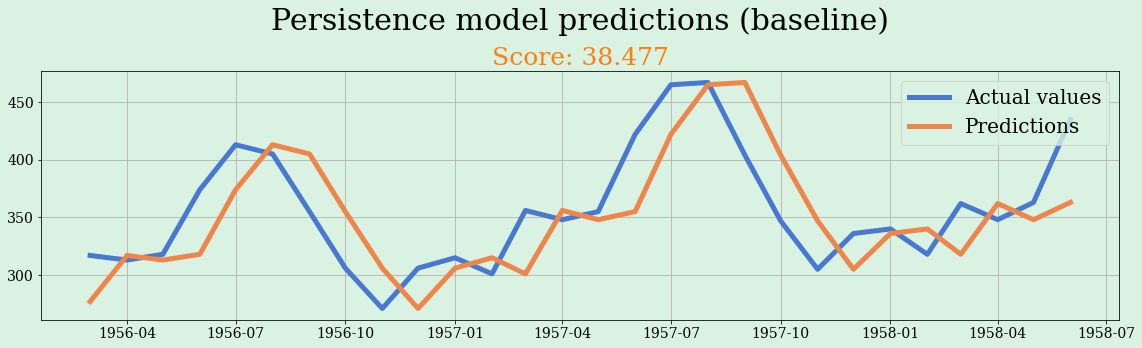

In [8]:
def persistence_predictions(train, test):
    predictions = test.shift(1)
    predictions[0] = train[-1]
    return predictions

def plot_predictions(values, predictions, title='', ax=None):
    score = score_model(values, predictions)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(values, label='Actual values')
    ax.plot(predictions, label='Predictions')
    ax.text(0.5, 1.2, f'{title}', ha="center", va="center",
            transform = ax.transAxes, size=30)
    ax.set_title(f'Score: {score}', color=orange)
    ax.legend(prop={'size': 20})
    plt.tight_layout();

baseline_val_preds = persistence_predictions(train, validation)
plot_predictions(validation, baseline_val_preds, title='Persistence model '
                                                   'predictions (baseline)')
baseline_val_score = score_model(validation, baseline_val_preds)
baseline_test_preds = persistence_predictions(dataset, test)
baseline_test_score = score_model(test, baseline_test_preds)

In [9]:
# Create a DataFrame with scores
score_df = pd.DataFrame(columns=['ModelName', 'Source', 'Order',
                                 'SeasonalOrder',
                                 'ValidationScore', 'TestScore'])

In [10]:
def update_scores(score_df, modelname, source, order=None, seasonal_order=None,
                  validation_score=None, test_score=None):
    if modelname not in score_df['ModelName'].values:
        model_dict = dict()
        model_dict['ModelName'] = modelname
        model_dict['Source'] = source
        model_dict['Order'] = order
        model_dict['SeasonalOrder'] = seasonal_order
        model_dict['ValidationScore'] = validation_score
        model_dict['TestScore'] = test_score
        score_df = score_df.append(model_dict, ignore_index=True)
    return score_df

score_df = update_scores(score_df, 'Persistence', 'Baseline', order=None,
                         seasonal_order=None,
                         validation_score=baseline_val_score,
                         test_score=baseline_test_score)

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
background:#daf2e1; border-radius: 20px;
">Step 2 results:</h2>

### 1. **Split data** into the train, validation and test sets.
### 2.  **Established a baseline** to check future predictions against. Baseline validation score: 38.477.
### 3. **RMSE** will be used as a scoring metric.

<div id="step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Choosing starting SARIMAX parameters. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Check if the data is stationary with Dickey-Fuller test.</h3>

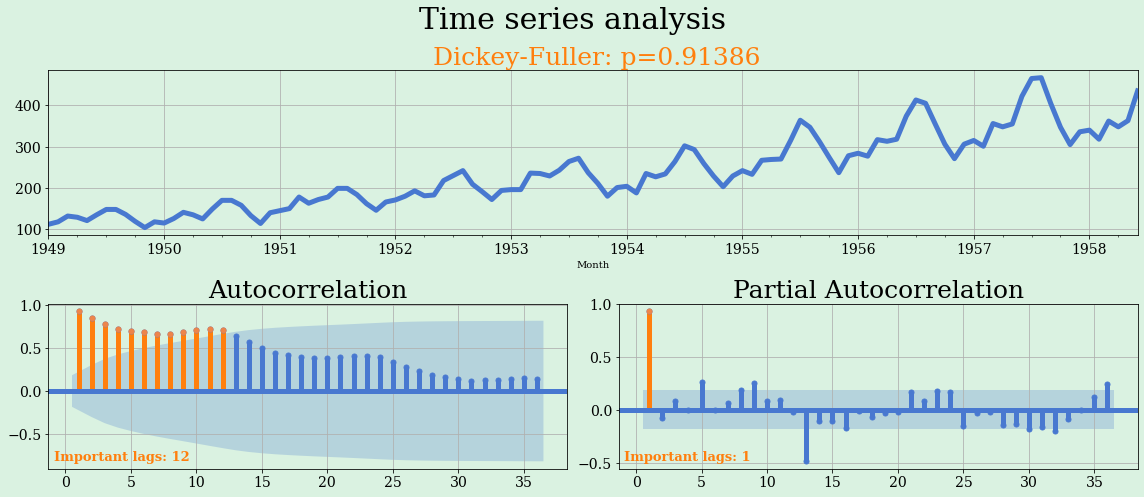

In [11]:
def adfuller_test_results(X):
    result = adfuller(X)
    print(f'ADF statistic:{result[0]:.3f}')
    print(f'p-value: {result[1]:.5f}')
    print(f'Used lags: {result[2]}')
    print(f'Used observations: {result[3]}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'{key}: {value:.3f}')
    print(f'Maximized information criteria: {result[5]:.3f}')

def tsplot(y, lags=None, figsize=(16, 7), title='Time series analysis',
           important_acf=None, important_pacf=None):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    fig.suptitle(title)
    ts_ax.set_title(f' Dickey-Fuller: p={p_value:.5f}',
                    color=orange)
    plot_acf(y, lags=lags, ax=acf_ax,
             zero=False)
    plot_pacf(y, lags=lags, ax=pacf_ax,
              zero=False)
    if important_acf:
        plot_acf(y, lags=important_acf, ax=acf_ax,
                  vlines_kwargs={"colors": orange},
                  zero=False, alpha=None)
        acf_ax.text(0.01, 0.05, f'Important lags: {important_acf}',
                    transform = acf_ax.transAxes, size=13, fontweight='bold',
                    color=orange)
    if important_pacf:
        plot_pacf(y, lags=important_pacf, ax=pacf_ax,
                  vlines_kwargs={"colors": orange},
                  zero=False, alpha=None)
        pacf_ax.text(0.01, 0.05, f'Important lags: {important_pacf}',
            transform = pacf_ax.transAxes, size=13, fontweight='bold',
            color=orange)
    plt.tight_layout();

tsplot(dataset, lags=36, important_acf=12, important_pacf=1)

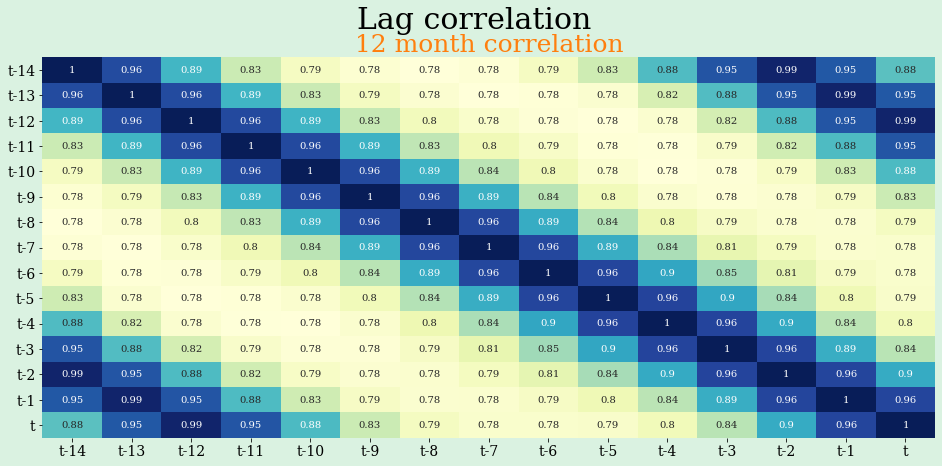

In [12]:
def cor_lags(series, n_lags=3):
    values = pd.DataFrame(series.values)
    dataframe = \
        pd.concat([values.shift(i) for i in reversed(range(1, n_lags + 1))]
                  + [values],axis=1)
    dataframe.columns = \
        ['t-' + str(i) for i in reversed(range(1, n_lags + 1))] + ['t']
    results = dataframe.corr()
    fig, ax = plt.subplots(figsize=(16, 7))
    sns.heatmap(results, annot=True, ax=ax, cmap="YlGnBu", cbar=False)
    fig.suptitle('Lag correlation')
    ax.set_title('12 month correlation', color=orange)
cor_lags(series, n_lags=14)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">The data is not stationary, need to remove seasonality.</h3>

$
\ \huge value_{(t)} = observation_{(t)} - observation_{(t-12)}
$

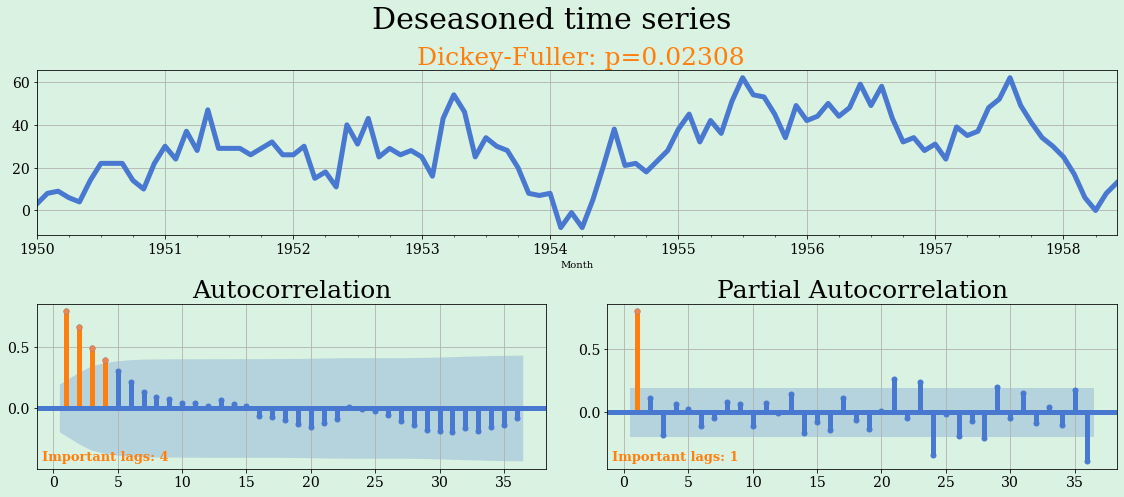

In [13]:
dataset_deseason = dataset.diff(12)[12:]
tsplot(dataset_deseason, lags=36, title='Deseasoned time series',
       important_acf=4, important_pacf=1)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">There are still lots of important lags in autocorrelation plot.
Need to calculate difference.</h3>
$
\ \huge value_{(t)} = observation_{(t)} - observation_{(t-1)}
$

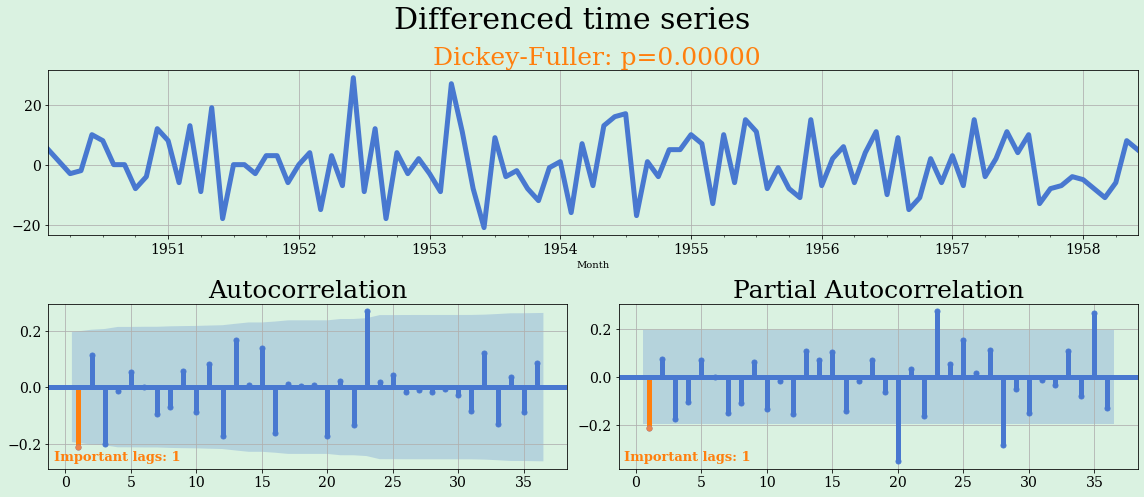

In [14]:
dataset_diff = dataset_deseason.diff(1)[1:]
tsplot(dataset_diff, lags=36, title='Differenced time series',
       important_acf=1, important_pacf=1)

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 3 results:</h2>

### 1. **Meaningful lags**: on ACF: 1 or 3, on PACF: 1
### 2. Used **differencing** and **removed seasonality**.
### 3. No seasonal meaningful lags left on ACF and PACF plots.
### 4. The first model to try: **SARIMAX(1, 1, 1,) (0, 1, 0, 12)**

<div id="step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. SARIMAX. </span>

In [15]:
def sarimax_predictions(train, test, order, seasonal_order):
    predictions = pd.Series()
    history = [x for x in train]
    for i in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions[test.index[i]] = yhat
        obs = test[i]
        history.append(obs)
    return predictions

In [16]:
order = (1, 1, 1)
seasonal_order = (0, 1, 0, 12)
validation_predictions = sarimax_predictions(train, validation, order=order,
                                      seasonal_order=seasonal_order)
validation_score = score_model(validation, validation_predictions)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Fitting the model with previously selected parameters.</h3>


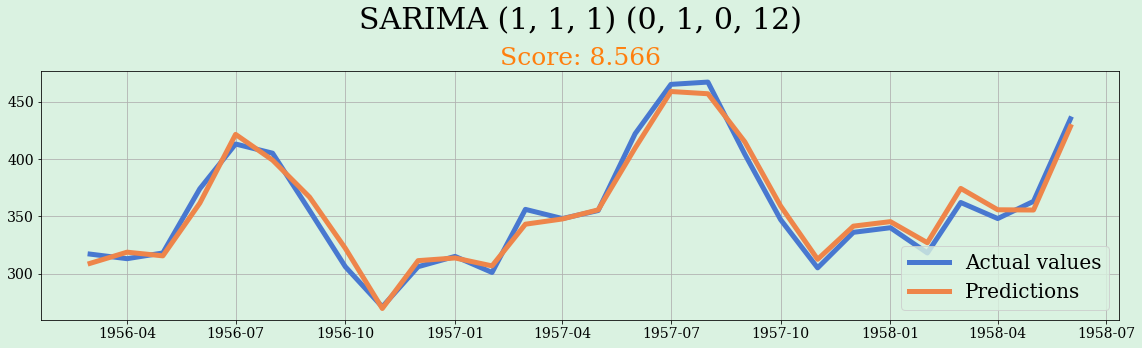

In [17]:
plot_predictions(validation, validation_predictions,
                 title=f'SARIMAX {order} {seasonal_order}')
score_df = update_scores(score_df, f'SARIMAX {order} {seasonal_order}',
                         'Hand selected', order=order,
                         seasonal_order=seasonal_order, validation_score=validation_score)

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 4 results:</h2>

### 1. Manually selected model shows **decent score** and **follows data patterns**.

<div id="step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5.	SARIMAX grid search. </span>

In [18]:
# setting initial values and some bounds for them
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 12
# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Use grid search to find model with best hyperparameters.</h3>

[Source](https://mlcourse.ai/articles/topic9-part1-time-series/)

In [19]:
def optimizeSARIMAX(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """
    results = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=SARIMAX(dataset, order=(param[0], d, param[1]),
                          seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = \
        result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [20]:
result_table = optimizeSARIMAX(parameters_list, d, D, s)

  0%|          | 0/100 [00:00<?, ?it/s]

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Using two best models from grid search</h3>


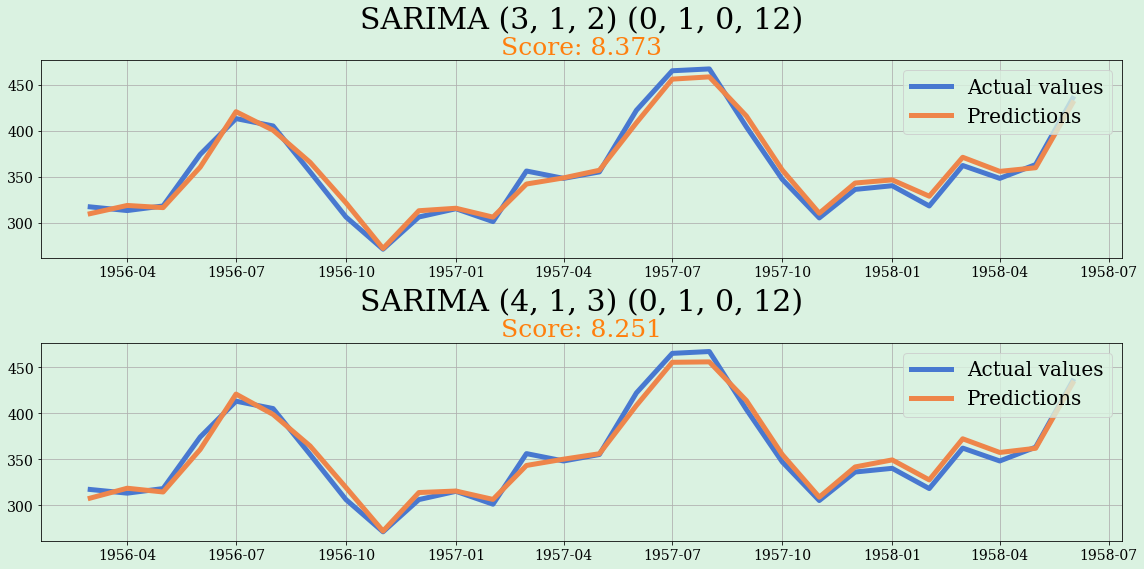

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
n_models = 2

for i in range(n_models):
    ax = axes.ravel()[i]
    model_params = result_table.iloc[i]['parameters']
    best_order = (model_params[0], d, model_params[1])
    best_seasonal_order = (model_params[2], D, model_params[3], s)
    validation_predictions = \
        sarimax_predictions(train, validation, order=best_order,
                            seasonal_order=best_seasonal_order)
    grid_search_score = score_model(validation, validation_predictions)
    plot_predictions(validation, validation_predictions,
                     title=f'SARIMAX {best_order} {best_seasonal_order}',
                     ax=ax)
    score_df = update_scores(score_df, f'SARIMAX {best_order} '
                                       f'{best_seasonal_order}',
                             'OptimizeArima', order=best_order,
                             seasonal_order=best_seasonal_order,
                             validation_score=grid_search_score)
plt.tight_layout()

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 5 results:</h2>

### 1. Model **SARIMAX (4, 1,3) (0, 1, 0, 12)** slightly outperforms model SARIMAX (1, 1, 1) (0, 1, 0, 12) on the validation set.
### 2. Added 2 best models from grid search for final evaluation.


<div id="step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6.	Check residuals. </span>

In [22]:
def analyze_residuals(residuals, lags=20, model_name=None):
    # Ideal residuals should be like white noise:
    # 1. Stationary (Fuller test p value < 0.05)
    # 2. Mean about 0.
    # 3. Gaussian distribution.
    # 4. Low variance (shows how good the model is).

    fig = plt.figure(figsize=(16, 10))
    layout = (3, 2)
    resid_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    hist_ax = plt.subplot2grid(layout, (1, 0))
    qq_ax = plt.subplot2grid(layout, (1, 1))
    acf_ax = plt.subplot2grid(layout, (2, 0))
    pacf_ax = plt.subplot2grid(layout, (2, 1))
    fig.suptitle(model_name, size=25)
    # Plot residual errors to look for patterns
    residuals.plot(ax=resid_ax)
    resid_ax.set_title(f'Mean = {residuals.mean():.3f}', loc='left',
                       color=orange)
    resid_ax.set_title(f'Variance: {residuals.var():.3f}', loc='center',
                       color=orange)
    resid_ax.set_title(f'Dickey-Fuller: {adfuller(residuals)[1]:.3f}',
                       loc='right', color=orange)
    # Residual errors histogram and density plot
    residuals.hist(ax=hist_ax)
    residuals.plot(kind='kde', ax=hist_ax, secondary_y=True)
    hist_ax.set_title('Histogram and KDE')

    # Residuals QQ plot
    # Check the distributions with QQ-Plots. If the dots are not on the
    # diagonal line, the distribution is not normal.
    qqplot(residuals, ax=qq_ax, fit=True, color=blue)
    qqline(ax=qq_ax, line='45', color=orange)
    qq_ax.set_title('QQ plot')

    # Residuals autocorrelation plot
    plot_acf(residuals, zero=False, lags=lags, ax=acf_ax)
    acf_ax.set_title('Autocorrelation plot')

    # Partial autocorrelation
    plot_pacf(residuals, zero=False, lags=lags, ax=pacf_ax)
    pacf_ax.set_title('Partial autocorrelation plot')

    plt.tight_layout()

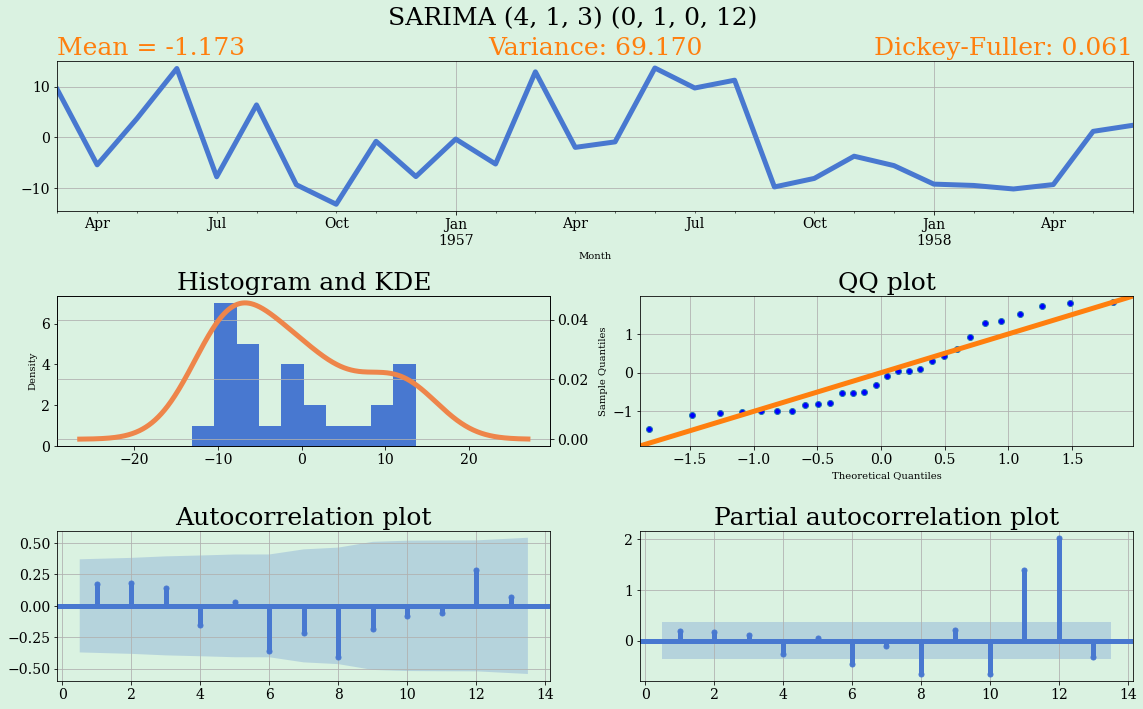

In [23]:
score_df.sort_values('ValidationScore', inplace=True)
best_model = \
    score_df.iloc[0]
validation_predictions = \
        sarimax_predictions(train, validation, order=best_model['Order'],
                  seasonal_order=best_model['SeasonalOrder'])
analyze_residuals(pd.Series(validation - validation_predictions), lags=13,
                  model_name=best_model['ModelName'])

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 6 results:</h2>

### 1. The residuals of best model are **not stationary**.
### 2. Distribution of residuals is **not normal**.
### 3. There is still room for **model improvement**.

<div id="step7">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 7. Test scoring. </span>

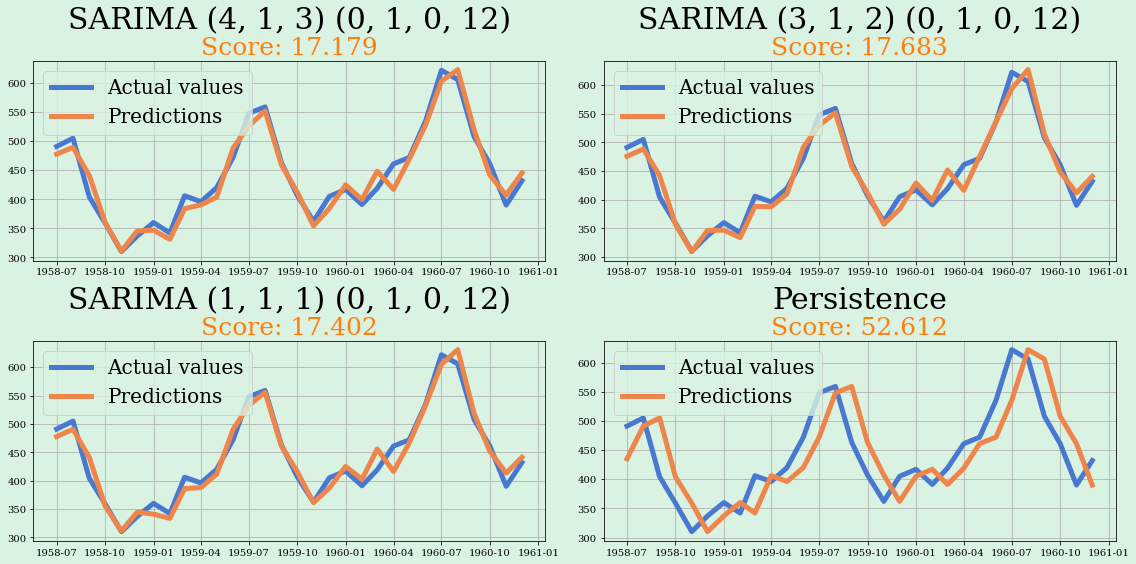

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
n_models = 4

for i in range(n_models):
    ax = axes.ravel()[i]
    model_params = score_df.iloc[i]
    if model_params['ModelName'] == 'Persistence':
        test_predictions = persistence_predictions(dataset, test)
        title = model_params['ModelName']
    else:
        best_order = model_params['Order']
        best_seasonal_order =  model_params['SeasonalOrder']
        test_predictions = \
            sarimax_predictions(dataset, test, order=best_order,
                                seasonal_order=best_seasonal_order)
        title = f'SARIMAX {best_order} {best_seasonal_order}'
    test_score = score_model(test, test_predictions)
    score_df['TestScore'].iloc[i] = test_score
    plot_predictions(test, test_predictions,
                     title=title,
                     ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)

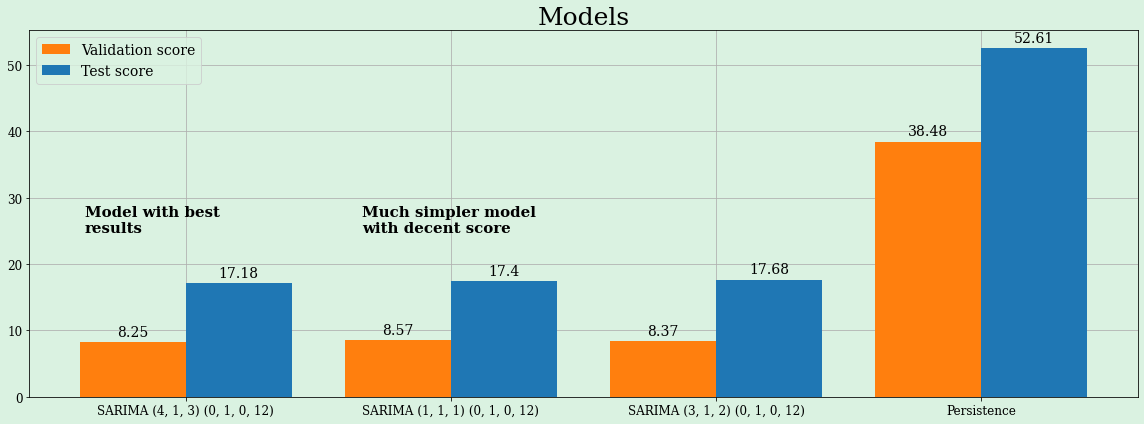

In [26]:
def autolabel(rects, ax, decimals=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        value = round(height, decimals)
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  size=14,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(16, 6))
score_df.sort_values(['TestScore'], inplace=True)
rects = ax.bar(x=score_df['ModelName'], height=score_df['ValidationScore'],
               color=orange, zorder=2, label='Validation score', width=-0.4,
               align='edge')
autolabel(rects, ax, decimals=2)
rects = ax.bar(x=score_df['ModelName'], height=score_df['TestScore'],
               color=blue, zorder=2, label='Test score', width=0.4,
               align='edge')
autolabel(rects, ax, decimals=2)
ax.legend(fontsize=14)
ax.set_title('Models')
ax.text(0.05, 0.45, 'Model with best\nresults',
             transform = ax.transAxes, size=15, fontweight='bold')
ax.text(0.30, 0.45, 'Much simpler model\nwith decent score',
             transform = ax.transAxes, size=15, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout();

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 7 results:</h2>

### 1. Model **SARIMAX(4, 1, 3) (0, 1, 0, 12) is the best model** based on test and validation scores.
### 2. Another options is to use a much simplier model **SARIMAX(1, 1, 1) (0, 1, 0, 12) with decent score** compared to the leader.

<div id="step8">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 8. Summary. </span>

### 1. Selected two final models: **SARIMAX(1, 1, 1) (0, 1, 0, 12) and SARIMAX(4, 1, 3) (0, 1, 0, 12)**.
### 2. Selected models **show predictive power** compared to baseline.
### 3. There is still space for model improvements as **residuals of models are not white noise**.

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Further analysis.</h3>

### 1. Use **power transfom** data to improve results.
### 2. Use **regression models** and feature engineering for alternative analysis.

<h2 style="padding: 30px; text-align: center; color:#01872A; font-size: 40px;
background:#daf2e1; border-radius: 20px;">
Thank you for reading. Any feedback is highly appreciated. </h2>